In [1]:
import numpy as np
import nibabel as nib
from dipy.io import streamline
import os
from glob import glob

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

/om2/user/ksitek/miniconda/envs/py3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/om2/user/ksitek/miniconda/envs/py3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


define region labels and order:

In [19]:
labels = ['LH_CN', 'LH_SOC', 'LH_IC', 'LH_MGB',
          'RH_CN', 'RH_SOC', 'RH_IC', 'RH_MGB']
labels_atlas = ['LH_CN', 'RH_CN', 'LH_SOC', 'RH_SOC', 
          'LH_IC', 'RH_IC', 'LH_MGB', 'RH_MGB']
#label_order = list(range(1,9)) # if regions are already in same order as labels
label_order = [1, 3, 5, 7, 2, 4, 6, 8]

define directories:

In [2]:
project_dir = os.path.abspath('/om2/user/ksitek/exvivo/')

## Full resolution, dilated ROI masks

In [9]:
processing_dir = os.path.join(project_dir, 'analysis/dipy/csd/',
                              'alow-0p001_angthr-75_minangle-10_fathresh-50_20190517_0.2mm_' \
                              'conj_kevin_v2_faruk_v1_dil-500um')
sl_dir = os.path.join(processing_dir, 'target_streamlines')

load streamlines and check the number of streamlines:

In [25]:
sl_file = os.path.join(sl_dir, 'all_atlas_streamlines.trk')
streamlines, hdr = streamline.load_trk(sl_file)
total_sl_count = hdr['nb_streamlines']
print('total streamlines = %d'%(total_sl_count))

total streamlines = 17725


In [26]:
# create a connectivity matrix from the seed-target streamline files
matrix_sl = np.zeros((len(labels), len(labels)))
for i, seed in enumerate(label_order):
    seed_label = labels_atlas[seed-1]
    print('seed: %s'%seed_label)
    for j, target in enumerate(label_order):
        target_label = labels_atlas[target-1]
        print('     target: %s'%target_label)
        try: 
            sl_file = os.path.join(sl_dir, 'target_streamlines_seed-%d_target-%d.trk'%(seed, target))
            streamlines, hdr = streamline.load_trk(sl_file)
            sl_count = hdr['nb_streamlines']
            print('             %d'%sl_count)
        except: sl_count = 0
        matrix_sl[i,j] = sl_count
matrix_sl = matrix_sl.astype(np.int) # convert to integers

# normalize the matrix by the total number of streamlines
norm_matrix_sl = matrix_sl/total_sl_count*100

# save matrix
txt_filename = os.path.join(sl_dir, 'sl_conn_mat.txt')
np.savetxt(txt_filename, matrix_sl)

seed: LH_CN
     target: LH_CN
             1572
     target: LH_SOC
             8
     target: LH_IC
             37
     target: LH_MGB
             5
     target: RH_CN
             0
     target: RH_SOC
             0
     target: RH_IC
             0
     target: RH_MGB
             0
seed: LH_SOC
     target: LH_CN
             8
     target: LH_SOC
             896
     target: LH_IC
             301
     target: LH_MGB
             178
     target: RH_CN
             0
     target: RH_SOC
             5
     target: RH_IC
             0
     target: RH_MGB
             0
seed: LH_IC
     target: LH_CN
             37
     target: LH_SOC
             301
     target: LH_IC
             1936
     target: LH_MGB
             396
     target: RH_CN
             0
     target: RH_SOC
             4
     target: RH_IC
             4
     target: RH_MGB
             0
seed: LH_MGB
     target: LH_CN
             5
     target: LH_SOC
             178
     target: LH_IC
             3

In [27]:
# create a custom color palette so that 0 is white (not light red)
new_cp = sns.color_palette("Reds",n_colors=10000)
new_cp[0] = [1,1,1]
new_cp[0:10]

[[1, 1, 1],
 (1.0, 0.9607843137254902, 0.9411764705882353),
 (1.0, 0.9607843137254902, 0.9411764705882353),
 (1.0, 0.9607843137254902, 0.9411764705882353),
 (1.0, 0.9607843137254902, 0.9411764705882353),
 (1.0, 0.9607843137254902, 0.9411764705882353),
 (1.0, 0.9607843137254902, 0.9411764705882353),
 (1.0, 0.9607843137254902, 0.9411764705882353),
 (1.0, 0.9607843137254902, 0.9411764705882353),
 (1.0, 0.9607843137254902, 0.9411764705882353)]

In [28]:
# make plot labels
norm_mat_str = []
for rx, row in enumerate(norm_matrix_sl):
    norm_mat_str_row = [str(i) for i in row]
    str_row = [j[:4] for j in norm_mat_str_row]
    norm_mat_str.append(str_row)
norm_mat_str_arr = np.array(norm_mat_str)

/om2/user/ksitek/exvivo/analysis/dipy/csd/alow-0p001_angthr-75_minangle-10_fathresh-50_20190517_0.2mm_conj_kevin_v2_faruk_v1/target_streamlines/streamline_norm_heatplot.png


<Figure size 432x288 with 0 Axes>

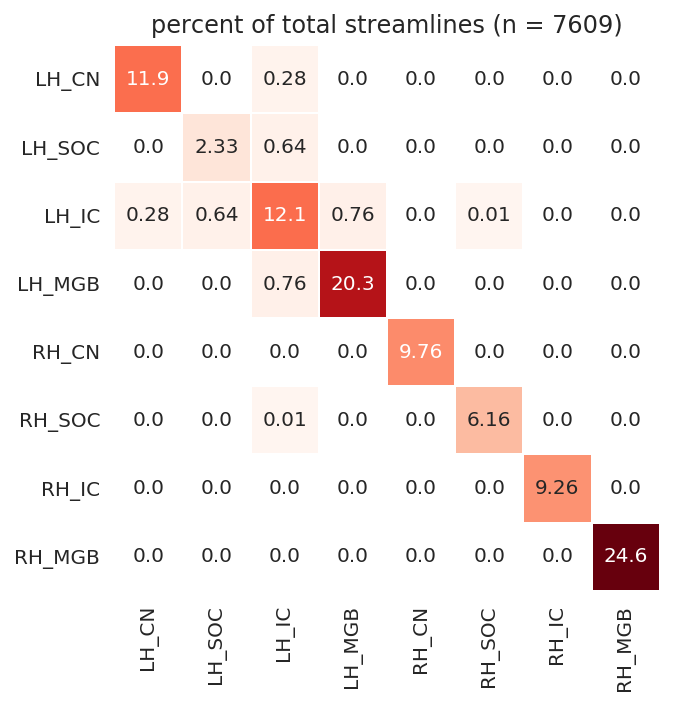

In [48]:
# make normalized streamline count plot
plt.clf()
plt.figure(figsize=(5,5))

mask = np.zeros_like(norm_matrix_sl)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(norm_matrix_sl, annot=norm_mat_str_arr, fmt="s", linewidths=.5,# ax=ax,
    #ax = sns.heatmap(norm_matrix_sl, annot=True, fmt=".02f", linewidths=.5,# ax=ax,
                xticklabels=labels, yticklabels=labels, square=True,#mask=mask, 
                cmap=new_cp, cbar=False);
ax.set(title='percent of total streamlines (n = %d)'%(total_sl_count));
plt.tight_layout()

# save plot
out_file = os.path.join(sl_dir, 'streamline_norm_heatplot.png')
print(out_file)
ax.figure.savefig(out_file, box_inches='tight', dpi=200)

/om2/user/ksitek/exvivo/analysis/dipy/csd/alow-0p001_angthr-75_minangle-10_fathresh-50_20190517_0.2mm_conj_kevin_v2_faruk_v1_dil-500um/target_streamlines/streamline_heatplot.png


<Figure size 432x288 with 0 Axes>

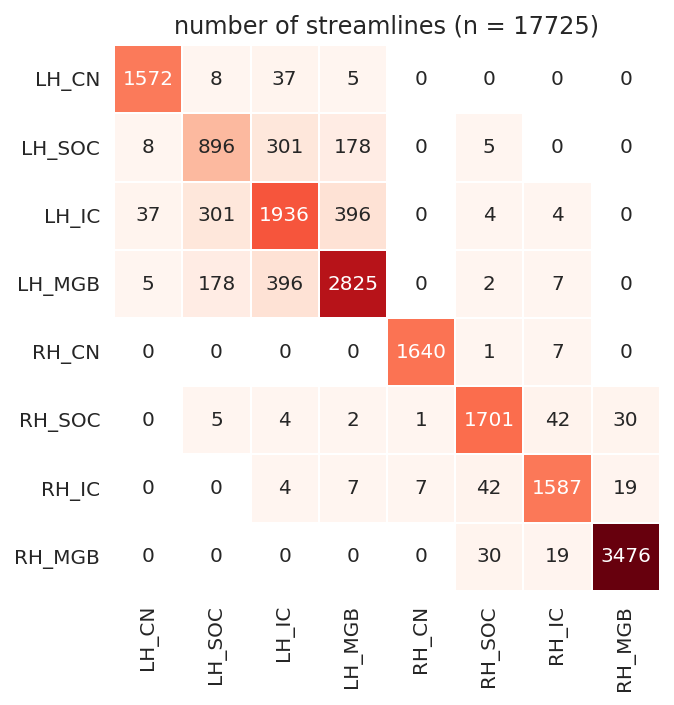

In [39]:
# make streamline count plot
plt.clf()
plt.figure(figsize=(5,5))

mask = np.zeros_like(matrix_sl)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(matrix_sl, annot=True, fmt="d", linewidths=.5,# ax=ax,
                xticklabels=labels, yticklabels=labels, square=True,#mask=mask, 
                cmap=new_cp, cbar=False);
ax.set(title='number of streamlines (n = %d)'%total_sl_count);
plt.tight_layout()

# save plot
out_file = os.path.join(sl_dir, 'streamline_heatplot.png')
print(out_file)
ax.figure.savefig(out_file, box_inches='tight', dpi=200)


## Full resolution, original ROI masks

In [40]:
processing_dir = os.path.join(project_dir, 'analysis/dipy/csd/',
                              'alow-0p001_angthr-75_minangle-10_fathresh-50_20190517_0.2mm_' \
                              'conj_kevin_v2_faruk_v1')
sl_dir = os.path.join(processing_dir, 'target_streamlines')

load streamlines and check the number of streamlines:

In [41]:
sl_file = os.path.join(sl_dir, 'all_atlas_streamlines.trk')
streamlines, hdr = streamline.load_trk(sl_file)
total_sl_count = hdr['nb_streamlines']
print('total streamlines = %d'%(total_sl_count))

total streamlines = 7609


In [42]:
# create a connectivity matrix from the seed-target streamline files
matrix_sl = np.zeros((len(labels), len(labels)))
for i, seed in enumerate(label_order):
    seed_label = labels_atlas[seed-1]
    print('seed: %s'%seed_label)
    for j, target in enumerate(label_order):
        target_label = labels_atlas[target-1]
        print('     target: %s'%target_label)
        try: 
            sl_file = os.path.join(sl_dir, 'target_streamlines_seed-%d_target-%d.trk'%(seed, target))
            streamlines, hdr = streamline.load_trk(sl_file)
            sl_count = hdr['nb_streamlines']
            print('             %d'%sl_count)
        except: sl_count = 0
        matrix_sl[i,j] = sl_count
matrix_sl = matrix_sl.astype(np.int) # convert to integers

# normalize the matrix by the total number of streamlines
norm_matrix_sl = matrix_sl/total_sl_count*100

# save matrix
txt_filename = os.path.join(sl_dir, 'sl_conn_mat.txt')
np.savetxt(txt_filename, matrix_sl)

seed: LH_CN
     target: LH_CN
             909
     target: LH_SOC
             0
     target: LH_IC
             22
     target: LH_MGB
             0
     target: RH_CN
             0
     target: RH_SOC
             0
     target: RH_IC
             0
     target: RH_MGB
             0
seed: LH_SOC
     target: LH_CN
             0
     target: LH_SOC
             178
     target: LH_IC
             49
     target: LH_MGB
             0
     target: RH_CN
             0
     target: RH_SOC
             0
     target: RH_IC
             0
     target: RH_MGB
             0
seed: LH_IC
     target: LH_CN
             22
     target: LH_SOC
             49
     target: LH_IC
             923
     target: LH_MGB
             58
     target: RH_CN
             0
     target: RH_SOC
             1
     target: RH_IC
             0
     target: RH_MGB
             0
seed: LH_MGB
     target: LH_CN
             0
     target: LH_SOC
             0
     target: LH_IC
             58
     ta

In [43]:
# create a custom color palette so that 0 is white (not light red)
new_cp = sns.color_palette("Reds",n_colors=10000)
new_cp[0] = [1,1,1]
new_cp[0:10]

[[1, 1, 1],
 (1.0, 0.9607843137254902, 0.9411764705882353),
 (1.0, 0.9607843137254902, 0.9411764705882353),
 (1.0, 0.9607843137254902, 0.9411764705882353),
 (1.0, 0.9607843137254902, 0.9411764705882353),
 (1.0, 0.9607843137254902, 0.9411764705882353),
 (1.0, 0.9607843137254902, 0.9411764705882353),
 (1.0, 0.9607843137254902, 0.9411764705882353),
 (1.0, 0.9607843137254902, 0.9411764705882353),
 (1.0, 0.9607843137254902, 0.9411764705882353)]

In [44]:
# make plot labels
norm_mat_str = []
for rx, row in enumerate(norm_matrix_sl):
    norm_mat_str_row = [str(i) for i in row]
    str_row = [j[:4] for j in norm_mat_str_row]
    norm_mat_str.append(str_row)
norm_mat_str_arr = np.array(norm_mat_str)

/om2/user/ksitek/exvivo/analysis/dipy/csd/alow-0p001_angthr-75_minangle-10_fathresh-50_20190517_0.2mm_conj_kevin_v2_faruk_v1/target_streamlines/streamline_norm_heatplot.png


<Figure size 432x288 with 0 Axes>

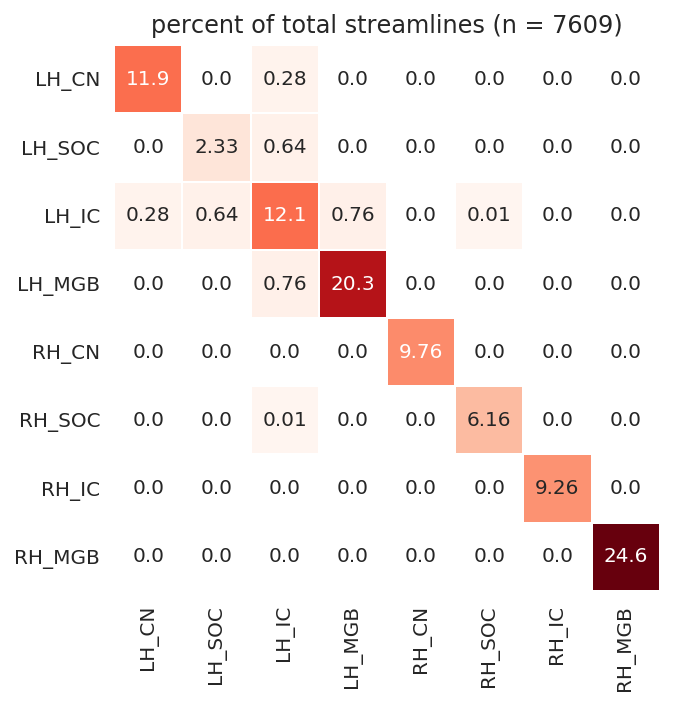

In [47]:
# make normalized streamline count plot
plt.clf()
plt.figure(figsize=(5,5))

mask = np.zeros_like(norm_matrix_sl)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(norm_matrix_sl, annot=norm_mat_str_arr, fmt="s", linewidths=.5,# ax=ax,
    #ax = sns.heatmap(norm_matrix_sl, annot=True, fmt=".02f", linewidths=.5,# ax=ax,
                xticklabels=labels, yticklabels=labels, square=True,#mask=mask, 
                cmap=new_cp, cbar=False);
ax.set(title='percent of total streamlines (n = %d)'%(total_sl_count));
plt.tight_layout()

# save plot
out_file = os.path.join(sl_dir, 'streamline_norm_heatplot.png')
print(out_file)
ax.figure.savefig(out_file, box_inches='tight', dpi=200)

/om2/user/ksitek/exvivo/analysis/dipy/csd/alow-0p001_angthr-75_minangle-10_fathresh-50_20190517_0.2mm_conj_kevin_v2_faruk_v1/target_streamlines/streamline_heatplot.png


<Figure size 432x288 with 0 Axes>

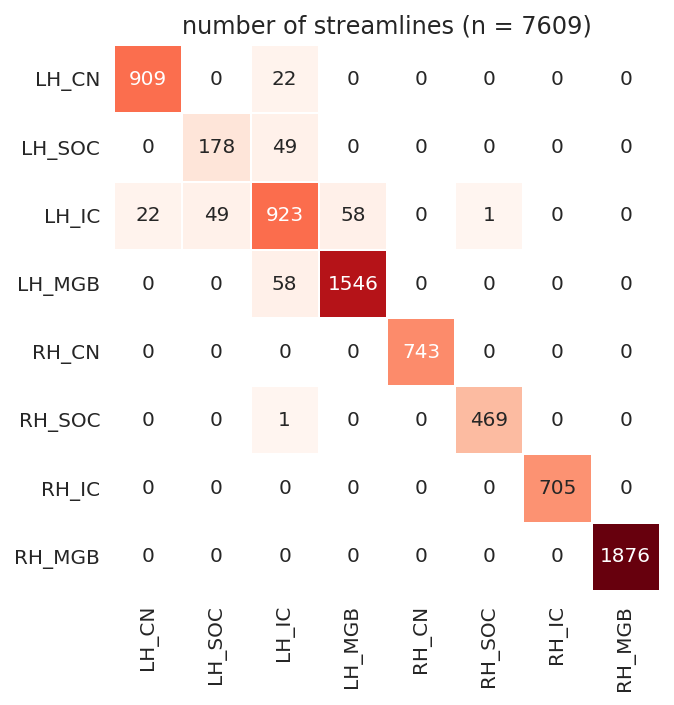

In [46]:
# make streamline count plot
plt.clf()
plt.figure(figsize=(5,5))

mask = np.zeros_like(matrix_sl)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(matrix_sl, annot=True, fmt="d", linewidths=.5,# ax=ax,
                xticklabels=labels, yticklabels=labels, square=True,#mask=mask, 
                cmap=new_cp, cbar=False);
ax.set(title='number of streamlines (n = %d)'%total_sl_count);
plt.tight_layout()

# save plot
out_file = os.path.join(sl_dir, 'streamline_heatplot.png')
print(out_file)
ax.figure.savefig(out_file, box_inches='tight', dpi=200)


## Downsampled resolution, original ROI masks

In [55]:
processing_dir = os.path.join(project_dir, 'analysis/dipy/csd/',
                              'alow-0p001_angthr-75_minangle-10_fathresh-50_20190523_1.05mm_' \
                              'conj_kevin_v2_faruk_v1')
sl_dir = os.path.join(processing_dir, 'target_streamlines')

load streamlines and check the number of streamlines:

In [56]:
sl_file = os.path.join(sl_dir, 'all_atlas_streamlines.trk')
streamlines, hdr = streamline.load_trk(sl_file)
total_sl_count = hdr['nb_streamlines']
print('total streamlines = %d'%(total_sl_count))

total streamlines = 16045


In [57]:
# create a connectivity matrix from the seed-target streamline files
matrix_sl = np.zeros((len(labels), len(labels)))
for i, seed in enumerate(label_order):
    seed_label = labels_atlas[seed-1]
    print('seed: %s'%seed_label)
    for j, target in enumerate(label_order):
        target_label = labels_atlas[target-1]
        print('     target: %s'%target_label)
        try: 
            sl_file = os.path.join(sl_dir, 'target_streamlines_seed-%d_target-%d.trk'%(seed, target))
            streamlines, hdr = streamline.load_trk(sl_file)
            sl_count = hdr['nb_streamlines']
            print('             %d'%sl_count)
        except: sl_count = 0
        matrix_sl[i,j] = sl_count
matrix_sl = matrix_sl.astype(np.int) # convert to integers

# normalize the matrix by the total number of streamlines
norm_matrix_sl = matrix_sl/total_sl_count*100

# save matrix
txt_filename = os.path.join(sl_dir, 'sl_conn_mat.txt')
np.savetxt(txt_filename, matrix_sl)

seed: LH_CN
     target: LH_CN
             1759
     target: LH_SOC
             0
     target: LH_IC
             2
     target: LH_MGB
             9
     target: RH_CN
             0
     target: RH_SOC
             0
     target: RH_IC
             0
     target: RH_MGB
             0
seed: LH_SOC
     target: LH_CN
             0
     target: LH_SOC
             828
     target: LH_IC
             56
     target: LH_MGB
             492
     target: RH_CN
             0
     target: RH_SOC
             0
     target: RH_IC
             0
     target: RH_MGB
             0
seed: LH_IC
     target: LH_CN
             2
     target: LH_SOC
             56
     target: LH_IC
             979
     target: LH_MGB
             144
     target: RH_CN
             0
     target: RH_SOC
             0
     target: RH_IC
             0
     target: RH_MGB
             0
seed: LH_MGB
     target: LH_CN
             9
     target: LH_SOC
             492
     target: LH_IC
             144
  

In [58]:
# create a custom color palette so that 0 is white (not light red)
new_cp = sns.color_palette("Reds",n_colors=10000)
new_cp[0] = [1,1,1]
new_cp[0:10]

[[1, 1, 1],
 (1.0, 0.9607843137254902, 0.9411764705882353),
 (1.0, 0.9607843137254902, 0.9411764705882353),
 (1.0, 0.9607843137254902, 0.9411764705882353),
 (1.0, 0.9607843137254902, 0.9411764705882353),
 (1.0, 0.9607843137254902, 0.9411764705882353),
 (1.0, 0.9607843137254902, 0.9411764705882353),
 (1.0, 0.9607843137254902, 0.9411764705882353),
 (1.0, 0.9607843137254902, 0.9411764705882353),
 (1.0, 0.9607843137254902, 0.9411764705882353)]

In [59]:
# make plot labels
norm_mat_str = []
for rx, row in enumerate(norm_matrix_sl):
    norm_mat_str_row = [str(i) for i in row]
    str_row = [j[:4] for j in norm_mat_str_row]
    norm_mat_str.append(str_row)
norm_mat_str_arr = np.array(norm_mat_str)

/om2/user/ksitek/exvivo/analysis/dipy/csd/alow-0p001_angthr-75_minangle-10_fathresh-50_20190523_1.05mm_conj_kevin_v2_faruk_v1/target_streamlines/streamline_norm_heatplot.png


<Figure size 432x288 with 0 Axes>

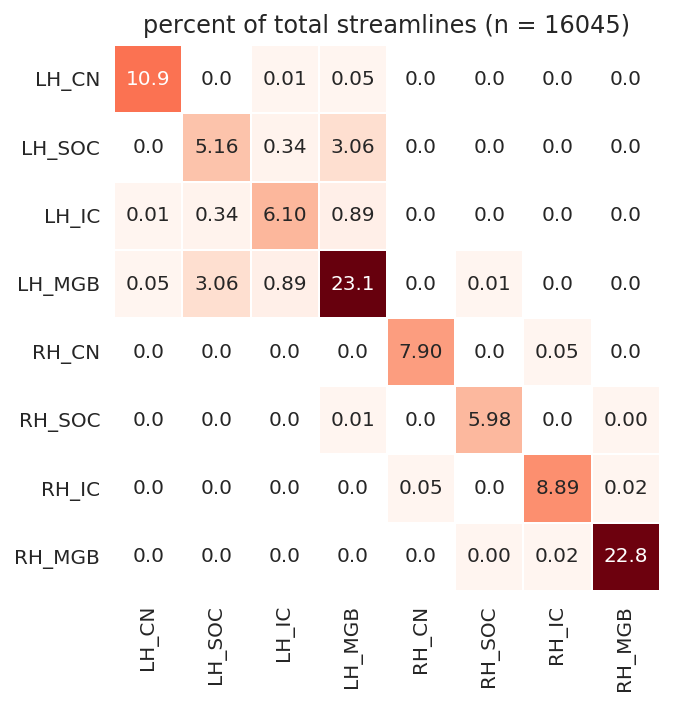

In [62]:
# make normalized streamline count plot
plt.clf()
plt.figure(figsize=(5,5))

mask = np.zeros_like(norm_matrix_sl)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(norm_matrix_sl, annot=norm_mat_str_arr, fmt="s", linewidths=.5,# ax=ax,
    #ax = sns.heatmap(norm_matrix_sl, annot=True, fmt=".02f", linewidths=.5,# ax=ax,
                xticklabels=labels, yticklabels=labels, square=True,#mask=mask, 
                cmap=new_cp, cbar=False);
ax.set(title='percent of total streamlines (n = %d)'%(total_sl_count));
plt.tight_layout()

# save plot
out_file = os.path.join(sl_dir, 'streamline_norm_heatplot.png')
print(out_file)
ax.figure.savefig(out_file, box_inches='tight', dpi=200)

/om2/user/ksitek/exvivo/analysis/dipy/csd/alow-0p001_angthr-75_minangle-10_fathresh-50_20190523_1.05mm_conj_kevin_v2_faruk_v1/target_streamlines/streamline_heatplot.png


<Figure size 432x288 with 0 Axes>

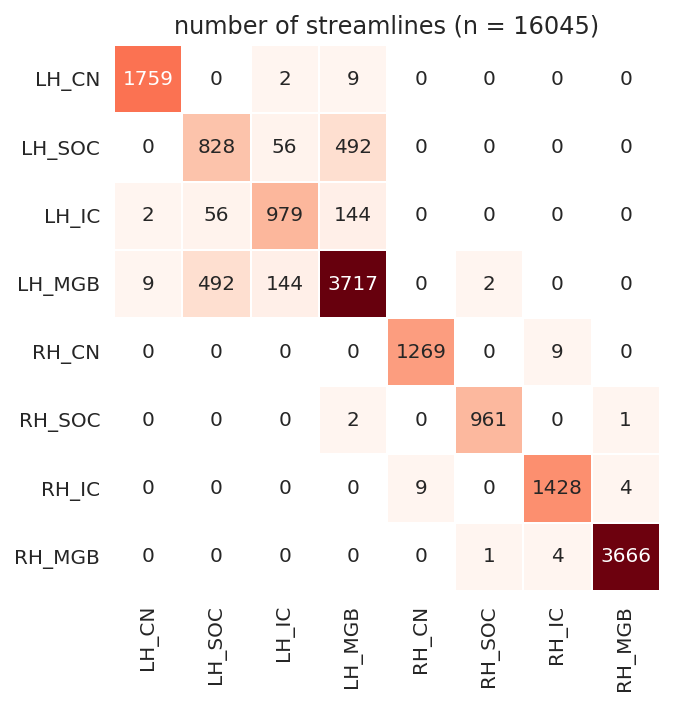

In [63]:
# make streamline count plot
plt.clf()
plt.figure(figsize=(5,5))

mask = np.zeros_like(matrix_sl)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(matrix_sl, annot=True, fmt="d", linewidths=.5,# ax=ax,
                xticklabels=labels, yticklabels=labels, square=True,#mask=mask, 
                cmap=new_cp, cbar=False);
ax.set(title='number of streamlines (n = %d)'%total_sl_count);
plt.tight_layout()

# save plot
out_file = os.path.join(sl_dir, 'streamline_heatplot.png')
print(out_file)
ax.figure.savefig(out_file, box_inches='tight', dpi=200)
